## Alumno: Matias Werbin

## Materia: Vision Computer I

# Enunciado

▪ Implementar la función `create_gauss_filter(h, w, k_size, sigma)` para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño `HxW` en dominio espacial y su transformada de Fourier.

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro a una imagen para validar el funcionamiento en el dominio espectral.

2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [23]:
def create_gaussian_filter(h, w, k_size, sigma):

    # Generar kernel gaussiano 1D
    gaussian_kernel_1d = cv2.getGaussianKernel(k_size, sigma)

    # Crear kernel gaussiano 2D utilizando la propiedad de separabilidad
    gaussian_kernel_2d = gaussian_kernel_1d @ gaussian_kernel_1d.T

    # Inicializar una matriz de ceros con las dimensiones de la imagen (h, w)
    frequency_filter = np.zeros((h, w), dtype=np.float32)

    # Colocar el kernel gaussiano en el centro de la matriz frequency_filter
    center_h, center_w = (h - k_size) // 2, (w - k_size) // 2
    frequency_filter[center_h:center_h + k_size, center_w:center_w + k_size] = gaussian_kernel_2d

    # Realizar la transformada de Fourier 2D a la matriz frequency_filter
    frequency_filter = np.fft.fft2(frequency_filter)

    # Aplicar fftshift para centrar el componente de frecuencia cero
    frequency_filter = np.fft.fftshift(frequency_filter)

    return gaussian_kernel_2d, frequency_filter

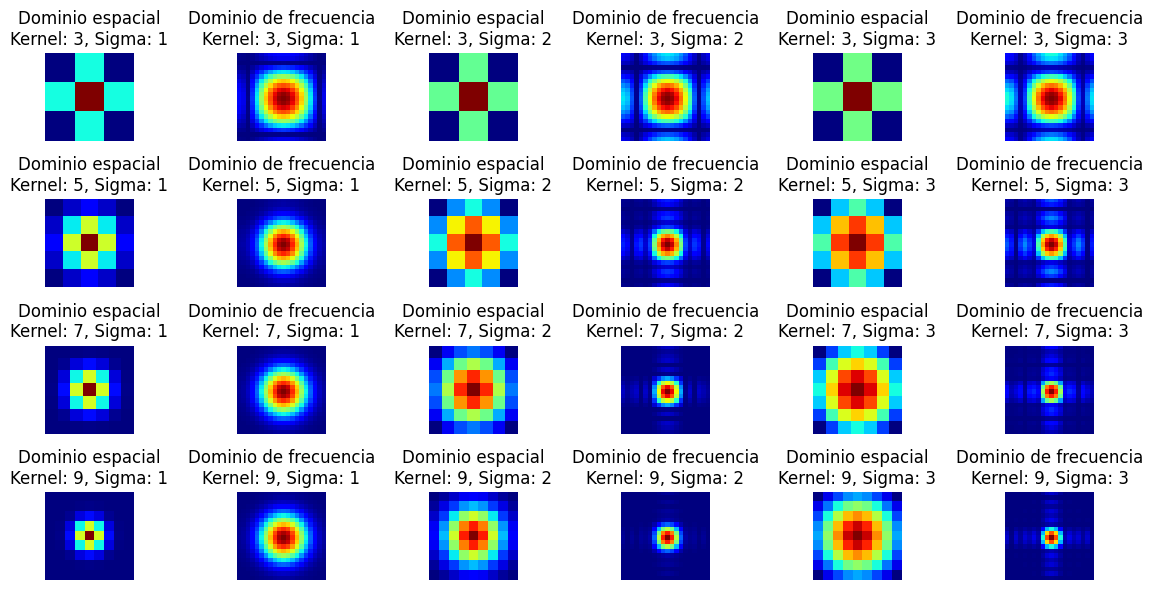

In [24]:
k_sizes = [3, 5, 7, 9]
sigmas = [1, 2, 3]
filter_size = (20,20)

fig, axes = plt.subplots(len(k_sizes), len(sigmas) * 2, figsize=(12, 6))

for i, k_size in enumerate(k_sizes):
    for j, sigma in enumerate(sigmas):
        gauss_spatial, gauss_freq = create_gaussian_filter(
            filter_size[0], filter_size[1], k_size, sigma
        )

        # filtros espaciales
        axes[i, j * 2].imshow(gauss_spatial, cmap="jet")
        axes[i, j * 2].set_title(f"Dominio espacial\nKernel: {k_size}, Sigma: {sigma}")
        axes[i, j * 2].axis("off")

        # filtro de frecuencias
        axes[i, j * 2 + 1].imshow(20*np.log(np.abs(gauss_freq) + 1), cmap="jet")
        axes[i, j * 2 + 1].set_title(
            f"Dominio de frecuencia\nKernel: {k_size}, Sigma: {sigma}"
        )
        axes[i, j * 2 + 1].axis("off")

plt.tight_layout()
plt.show()

In [25]:
chewy=cv2.imread('chewbacca.jpg',cv2.IMREAD_GRAYSCALE)

In [26]:
# inicializo valores
k_size,sigma=9,5
h,w=chewy.shape

In [27]:
gaussian_kernel_2d, frequency_filter=create_gaussian_filter(h,w,k_size,sigma)

In [28]:
# Transformada de Fourier y centrado
image_freq = np.fft.fft2(chewy)
image_freq = np.fft.fftshift(image_freq)

# Aplico filtro
filtered_freq = image_freq * frequency_filter

# Transformada de Fourier inversa para volver al dominio espacial (uso de valor absoluto para elimina residuo complejo)
filtered_image = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(filtered_freq))))

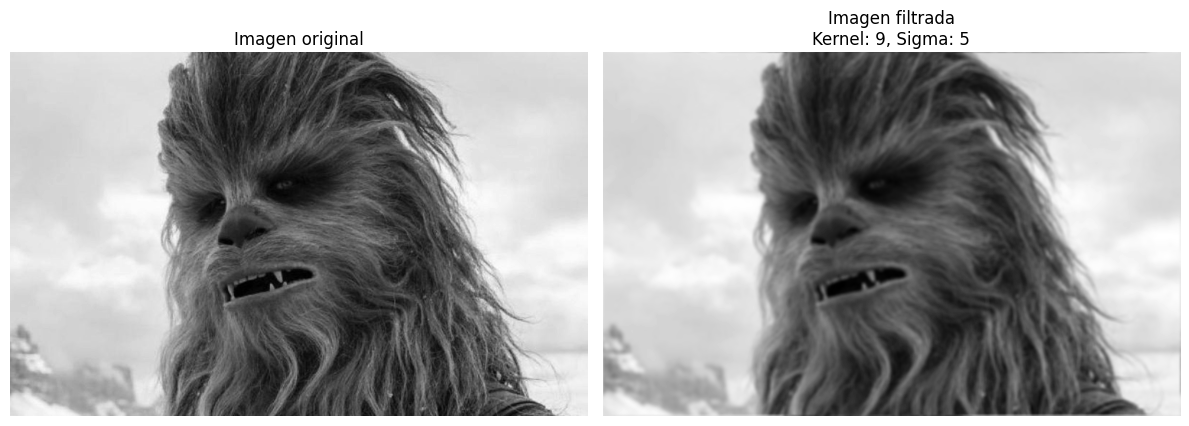

In [29]:
# Ploteo
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(chewy, cmap="gray")
ax[0].set_title("Imagen original")
ax[0].axis("off")

ax[1].imshow(filtered_image, cmap="gray")
ax[1].set_title(f"Imagen filtrada\nKernel: {k_size}, Sigma: {sigma}")
ax[1].axis("off")

plt.tight_layout()
plt.show()

### Algoritmo de medida de calidad de imagen

Paper: `Image Sharpness Measure for Blurred Images in Frequency Domain`

Input: Imagen $I$ de tamaño $M \times N$

Output: Medida de calidad de la imagen (FM) donde FM significa _Frequency Domain Image Blur Measure_

- Paso 1: Calcular $F$ que es la representación en transformada de Fourier (FFT) de la imagen $I$

- Paso 2: Encontrar $F c$ que se obtiene desplazando el origen de $F$ al centro

- Paso 3: Calcular $A F=a b s(F c)$ donde $\mathrm{AF}$ es el valor absoluto de la FFT centrada de la imagen I

- Paso 4: Calcular $M=\max (A F)$ donde $\mathrm{M}$ es el valor máximo del componente de frecuencia en $\mathrm{F}$

- Paso 5: Calcular $\mathrm{T}_{\mathrm{H}}=$ número total de píxeles en $F$ cuyo valor de píxel $>$ thres, donde thres $=M / 1000$

- Paso 6: Calcular Medida de calidad de la imagen (FM) con la ecuación de abajo:

$$
\text { Medida de calidad de la imagen }(F M)=\frac{T_H}{M \times N}

In [30]:
def quality_image(image):
    
    # Paso 1: Calcular F que es la representación en transformada de Fourier (FFT) de la imagen I
    F = np.fft.fft2(image)
    
    # Paso 2: Encontrar Fc que se obtiene desplazando el origen de F al centro
    Fc = np.fft.fftshift(F)
    
    # Paso 3: Calcular AF=abs(Fc) donde AF es el valor absoluto de la FFT centrada de la imagen I
    AF = np.abs(Fc)
    
    # Paso 4: Calcular M=max(AF) donde M es el valor máximo del componente de frecuencia en F
    M = np.max(AF)
    
    # Paso 5: Calcular TH= número total de píxeles en F cuyo valor de píxel > thres, donde thres=M/1000
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular Medida de calidad de la imagen (FM)
    FM = TH / (image.shape[0] * image.shape[1])
    
    return FM

In [31]:
# Calidad de imagen original

FM_orig=quality_image(chewy)

# Calidad de imagen con convolución gaussiana

image_conv=cv2.filter2D(chewy,-1,gaussian_kernel_2d)

FM_conv=quality_image(image_conv)

# Calidad de imagen mediante filtrado con FFT

FM_fourier=quality_image(filtered_image)


print(f'La calidad de la imagen original es: {round(FM_orig,5)}')
print(f'La calidad de la imagen convolucionada con filtro gaussioano es:{FM_conv:.5f}')
print(f'La calidad de la imagen filtrada con FFY es:{FM_fourier:.5f}')

La calidad de la imagen original es: 0.0032
La calidad de la imagen convolucionada con filtro gaussioano es:0.00262
La calidad de la imagen filtrada con FFY es:0.00249


(-0.5, 1199.5, 755.5, -0.5)

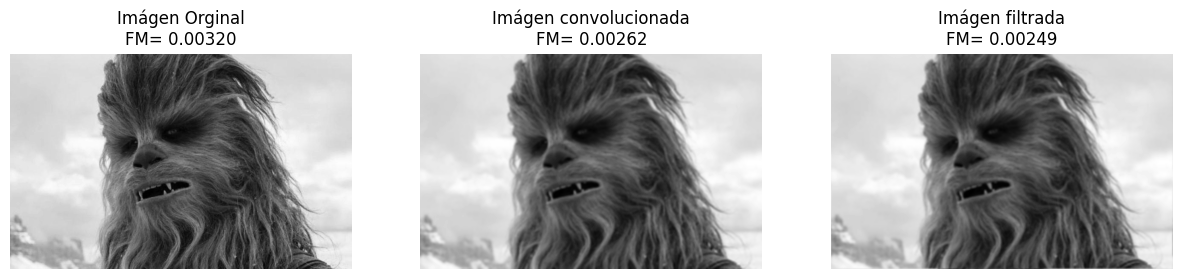

In [32]:
fig,ax = plt.subplots(1,3,figsize=(15,3))

ax[0].imshow(chewy,cmap='gray')
ax[0].set_title(f"Imágen Orginal\nFM= {FM_orig:.5f}")
ax[0].axis('off')
ax[1].imshow(image_conv,cmap='gray')
ax[1].set_title(f"Imágen convolucionada\nFM= {FM_conv:.5f}")
ax[1].axis('off')
ax[2].imshow(filtered_image,cmap='gray')
ax[2].set_title(f"Imágen filtrada\nFM= {FM_fourier:.5f}")
ax[2].axis('off')


### Algoritmos de medida de calidad de imagen

Paper: `Analysis of focus measure operators in shape-from-focus`

Se elige: `MIS3: Image Contrast`:

Nanda et al. [49] utilizaron el contraste de la imagen como una medida de enfoque para el autofoco.

$$ C(x,y) = \sum_{i=x-1}^{x+1} \sum_{j=y-1}^{y+1} |I(x,y) - I(i,j)|, $$

donde \( C(x,y) \) es el contraste de la imagen para el píxel \( I(x,y) \). Este operador se puede adaptar a SFF (Shape from Focus) si el contraste se acumula sobre el vecindario del píxel:

$$ f_{x,y} = \sum_{(i,j) \in O(x,y)} C(i,j), $$




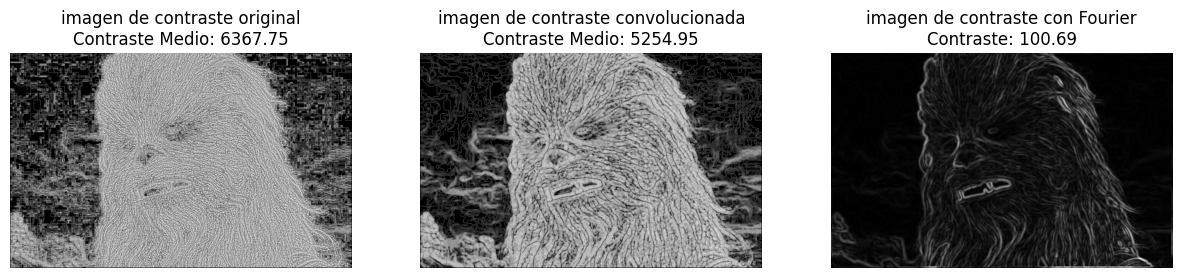

In [33]:
def calcular_contraste(imagen):
    if len(imagen.shape) == 3 and imagen.shape[2] == 3:
        # Convertir la imagen a escala de grises
        imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    else:
        imagen_gris = imagen

    # Obtener las dimensiones de la imagen
    
    h, w = imagen_gris.shape
    
    # Inicializar la imagen de contraste
    imagen_contraste = np.zeros((h, w), dtype=np.float32)
    
    # Calcular el contraste para cada píxel
    for x in range(1, w-1):
        for y in range(1, h-1):
            Ixy = imagen_gris[y, x]
            vecindario = imagen_gris[y-1:y+2, x-1:x+2]
            contraste = np.sum(np.abs(Ixy - vecindario))
            imagen_contraste[y, x] = contraste
    
    return imagen_contraste

def acumular_contraste(imagen_contraste):

    h, w = imagen_contraste.shape
    
    # Inicializar la imagen de contraste acumulado
    contraste_acumulado = np.zeros((h, w), dtype=np.float32)
    
    # Acumular el contraste en el vecindario
    for x in range(1, w-1):
        for y in range(1, h-1):
            vecindario = imagen_contraste[y-1:y+2, x-1:x+2]
            contraste_acumulado[y, x] = np.sum(vecindario)
    
    return contraste_acumulado


# Calcular la imagen de contraste
imagen_contraste_chewy = calcular_contraste(chewy)
imagen_contraste_conv = calcular_contraste(image_conv)
imagen_contraste_fourier = calcular_contraste(filtered_image)

# Acumular el contraste en el vecindario
imagen_contraste_acumulado_chewy = acumular_contraste(imagen_contraste_chewy)
imagen_contraste_acumulado_conv = acumular_contraste(imagen_contraste_conv)
imagen_contraste_acumulado_fourier = acumular_contraste(imagen_contraste_fourier)

# Normalizar imagenes de contraste acumulado para visualizarla
imagen_contraste_normalizada_chewy = cv2.normalize(imagen_contraste_acumulado_chewy, None, 0, 255, cv2.NORM_MINMAX)
imagen_contraste_normalizada_chewy = imagen_contraste_normalizada_chewy.astype(np.uint8)
imagen_contraste_normalizada_conv = cv2.normalize(imagen_contraste_acumulado_conv, None, 0, 255, cv2.NORM_MINMAX)
imagen_contraste_normalizada_conv = imagen_contraste_normalizada_conv.astype(np.uint8)
imagen_contraste_normalizada_fourier = cv2.normalize(imagen_contraste_acumulado_fourier, None, 0, 255, cv2.NORM_MINMAX)
imagen_contraste_normalizada_fouerie = imagen_contraste_normalizada_fourier.astype(np.uint8)

fig,axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(imagen_contraste_normalizada_chewy, cmap='gray')
axes[0].set_title(f'imagen de contraste original\nContraste Medio: {np.mean(imagen_contraste_acumulado_chewy):.2f}')
axes[0].axis('off')
axes[1].imshow(imagen_contraste_normalizada_conv, cmap='gray')
axes[1].set_title(f'imagen de contraste convolucionada\nContraste Medio: {np.mean(imagen_contraste_acumulado_conv):.2f}')
axes[1].axis('off')
axes[2].imshow(imagen_contraste_normalizada_fourier, cmap='gray')
axes[2].set_title(f'imagen de contraste con Fourier\nContraste: {np.mean(imagen_contraste_acumulado_fourier):.2f}')
axes[2].axis('off')
plt.show()

